In [1]:
import pandas as pd
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
from matplotlib import pyplot as plt

rgb_lower = [45,34,30]
rgb_higher = [255,219,172]

def extractSkin(image):
    img = image.copy()
    black_img = np.zeros((img.shape[0],img.shape[1],img.shape[2]),dtype=np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_threshold = np.array([0,10, 70], dtype=np.uint8)
    upper_threshold = np.array([20, 155, 255], dtype=np.uint8)
    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)
    skin = cv2.bitwise_and(img, img, mask=skinMask)
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)

def removeBlack(estimator_labels, estimator_cluster):
    hasBlack = False
    occurance_counter = Counter(estimator_labels)
    def compare(x, y): return Counter(x) == Counter(y)
    for x in occurance_counter.most_common(len(estimator_cluster)):
        color = [int(i) for i in estimator_cluster[x[0]].tolist()]
        if compare(color, [0, 0, 0]) == True:
            del occurance_counter[x[0]]
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster, x[0], 0)
            break
    return (occurance_counter, estimator_cluster, hasBlack)

def getColorInformation(estimator_labels, estimator_cluster, hasThresholding=False):
    occurance_counter = None
    colorInformation = []
    hasBlack = False
    if hasThresholding == True:
        (occurance, cluster, black) = removeBlack(
            estimator_labels, estimator_cluster)
        occurance_counter = occurance
        estimator_cluster = cluster
        hasBlack = black
    else:
        occurance_counter = Counter(estimator_labels)
    totalOccurance = sum(occurance_counter.values())
    for x in occurance_counter.most_common(len(estimator_cluster)):
        index = (int(x[0]))
        index = (index-1) if ((hasThresholding & hasBlack)
                              & (int(index) != 0)) else index
        color = estimator_cluster[index].tolist()
        color_percentage = (x[1]/totalOccurance)
        colorInfo = {"cluster_index": index, "color": color,
                     "color_percentage": color_percentage}
        colorInformation.append(colorInfo)
    return colorInformation

def extractDominantColor(image, number_of_colors=1, hasThresholding=False):
    if hasThresholding == True:
        number_of_colors += 1
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((img.shape[0]*img.shape[1]), 3)
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)
    estimator.fit(img)
    colorInformation = getColorInformation(
        estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation

def plotColorBar(colorInformation):
    color_bar = np.zeros((100, 500, 3), dtype="uint8")
    top_x = 0
    for x in colorInformation:
        bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])
        color = tuple(map(int, (x['color'])))
        cv2.rectangle(color_bar, (int(top_x), 0),
                      (int(bottom_x), color_bar.shape[0]), color, -1)
        top_x = bottom_x
    return color_bar


df=pd.read_csv(r'tone_exe.csv')
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['tone']=le.fit_transform(df['TONE'])
from sklearn.model_selection import train_test_split
X=df[['R', 'G', 'B']].values
Y=df[['tone']].values
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=0.6)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

lr=LogisticRegression()
rfr=RandomForestRegressor()
svc=SVC()
knn=KNeighborsClassifier(n_neighbors=5)
rc=RandomForestClassifier()

lr.fit(X_train,Y_train)
rfr.fit(X_train,Y_train)
svc.fit(X_train,Y_train)
knn.fit(X_train,Y_train)
rc.fit(X_train,Y_train)

Y_predlr=lr.predict(X_test)
Y_predrfr=rfr.predict(X_test)
Y_predsvc=svc.predict(X_test)
Y_predknn=knn.predict(X_test)
Y_predrc=rc.predict(X_test)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-1-373f4202c5b8>:107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train,Y_train)
C:\ProgramData\A

Enter image url :
fair

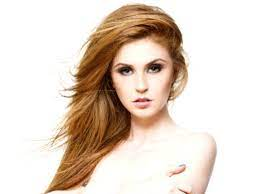

In [2]:
url = input("Enter image url :")

img = imutils.url_to_image(url)
# img=cv2.imread('modi.jpg')
img = imutils.resize(img, width=250)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')
faces = face_cascade.detectMultiScale(gray, 1.1, 4)

for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 4)
    faces = img[y:y + h, x:x + w]
    cv2.imwrite('face.jpg',faces)
    
image=cv2.imread('face.jpg')
skin = extractSkin(image)
unprocessed_dominant = extractDominantColor(skin, number_of_colors=1, hasThresholding=True)

decimal_lower = (rgb_lower[0] * 256 * 256) + (rgb_lower[1] * 256) + rgb_lower[2]
decimal_higher = (rgb_higher[0] * 256 * 256) + (rgb_higher[1] * 256) + rgb_higher[2]
dominantColors = []
for clr in unprocessed_dominant:
    clr_decimal = int((clr['color'][0] * 256 * 256) + (clr['color'][1] * 256) + clr['color'][2])
    if clr_decimal in range(decimal_lower,decimal_higher+1):
        clr['decimal_color'] = clr_decimal
        dominantColors.append(clr)

colour_bar = plotColorBar(dominantColors)
c=colour_bar[0][0]
c=list(c)

l=[]

l.append(list(lr.predict([c])))
l.append(list((rfr.predict([c]))))
l.append(list(svc.predict([c])))
l.append(list(knn.predict([c])))
l.append(list(rc.predict([c])))

k=[]
for i in range(len(l)):
    k.append(l[i][0])

from collections import Counter
freq=Counter(k)
size=len(l)
col=2
for (key,v) in freq.items():
    if(v>(size/2)):
        col=key

if col==1:
    print('fair')
elif col==0:
    print('dark')
elif col==2:
    print('mild')